# Undersea Cables

Dataset: https://www.kaggle.com/datasets/sndorburian/underwater-marine-data-cables/data 

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sndorburian/underwater-marine-data-cables")
print("Path to dataset files:", path)

Path to dataset files: /Users/kovy/.cache/kagglehub/datasets/sndorburian/underwater-marine-data-cables/versions/1


In [2]:
# Initial Data Load

import json
import pandas as pd
from shapely import MultiLineString
data = json.load(open("/Users/kovy/.cache/kagglehub/datasets/sndorburian/underwater-marine-data-cables/versions/1/underwatercable.json"))

df_undersea = pd.DataFrame(data["features"])
df_undersea.head()

,type,properties,geometry
0,Feature,"{'id': 'carnival-submarine-network-1-csn-1', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
1,Feature,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","{'type': 'MultiLineString', 'coordinates': [[[..."
2,Feature,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","{'type': 'MultiLineString', 'coordinates': [[[..."
3,Feature,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
4,Feature,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","{'type': 'MultiLineString', 'coordinates': [[[..."


In [3]:
import geopandas as gpd

# Geo-enrichment of the data

gdf_undersea = df_undersea.copy(deep=False)

name_list = []
id_list = []
color_list = []

for i in df_undersea.index:
    name_i = df_undersea.loc[i].properties["name"]
    name_list.append(name_i)
    id_i = df_undersea.loc[i].properties["id"]
    id_list.append(id_i)
    color_i = df_undersea.loc[i].properties["color"]
    color_list.append(color_i)

gdf_undersea["id"] = id_list
gdf_undersea["name"] = name_list
gdf_undersea["color"] = color_list

geom_list = []
for i in df_undersea.index:
    geom_i = MultiLineString(pd.DataFrame(data["features"]).geometry.loc[i]["coordinates"])
    geom_list.append(geom_i)


gdf_undersea = gpd.GeoDataFrame(gdf_undersea, geometry = geom_list)
gdf_undersea = gdf_undersea.set_crs(4326)
gdf_undersea = gdf_undersea[["id", "name", "color", "properties", "geometry"]]
gdf_undersea.head()

,id,name,color,properties,geometry
0,carnival-submarine-network-1-csn-1,Carnival Submarine Network-1 (CSN-1),#939597,"{'id': 'carnival-submarine-network-1-csn-1', '...","MULTILINESTRING ((-79.53671 8.96483, -79.42487..."
1,sea-h2x,SEA-H2X,#939597,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","MULTILINESTRING ((113.84999 17.10852, 116.9999..."
2,hronn,Hronn,#009f94,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","MULTILINESTRING ((5.40007 55.3559, 5.28757 55...."
3,cook-strait,Cook Strait,#951f63,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","MULTILINESTRING ((174.23597 -41.33903, 174.431..."
4,minoas-east-and-west,Minoas East and West,#939597,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","MULTILINESTRING ((23.03575 36.52322, 23.28756 ..."


Below, we plot the data using the freely available `natural_earth` geodataset (https://www.naturalearthdata.com/downloads/110m-cultural-vectors/)

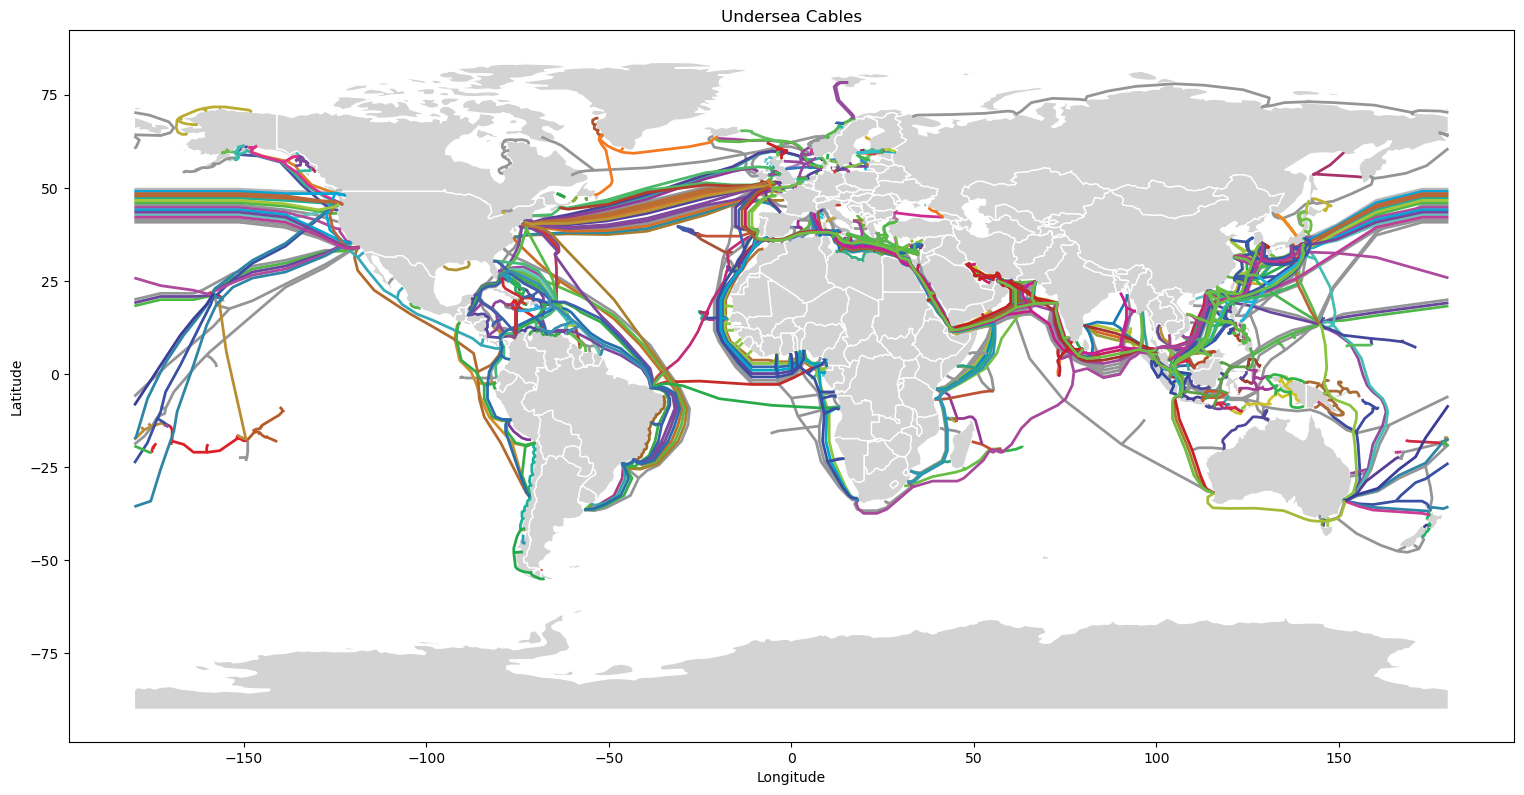

In [ ]:
import matplotlib.pyplot as plt

# Download world shapefile for plotting
world = gpd.read_file("./data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray', edgecolor='white')

gdf_undersea.plot(ax=ax, color=gdf_undersea["color"], linewidth=2, legend=True)

plt.title("Undersea Cables")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.savefig("undersea_cables_world.png", dpi=200) # Save to repo
plt.show()

If we zoom in, however, we find our first issue - the entries in the dataset are persisted using the `MultiLineString` format and therefore it can be problematic to try and represent them using standard measurements such as length or other statistics:

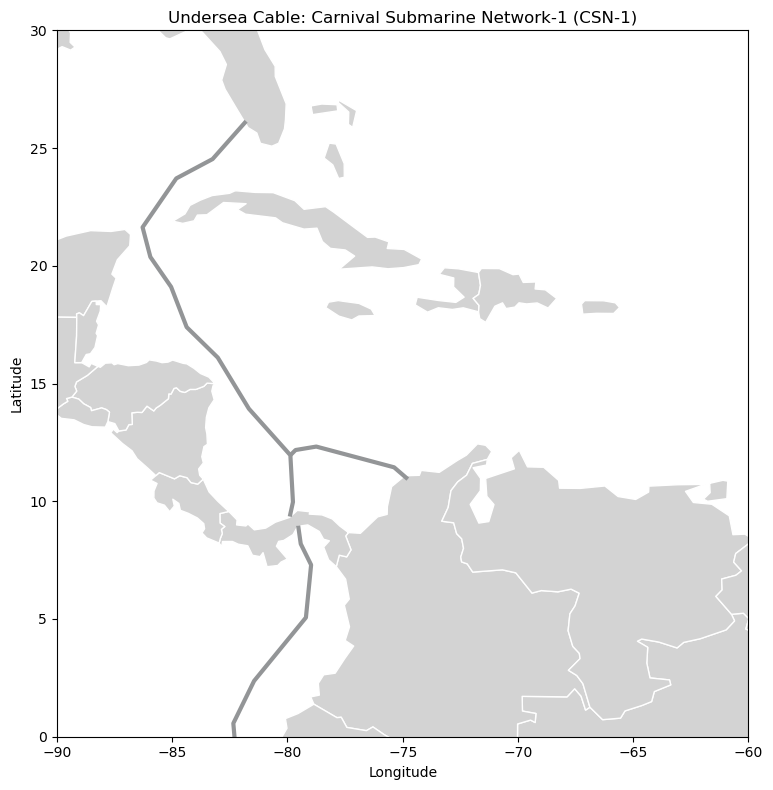

In [ ]:
# Plot the first cable (Caribbean region)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot world basemap
world = gpd.read_file("./data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot the first cable
gdf_undersea.iloc[0:1].plot(ax=ax, color=gdf_undersea.iloc[0]["color"], linewidth=3)

plt.title(f"Undersea Cable: {gdf_undersea.iloc[0]['name']}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-90, -60)  # Adjust as needed for the Caribbean
plt.ylim(0, 30)
plt.tight_layout()
plt.show()

Therefore, we have to take a detour - extract all points from each MultiLineString and represent each individual point as a node and the connection (`LineString`) between them as an edge to form the graph that will underpin our solution. For each node, however, we will also keep the `id` value of the undersea cable it belongs to as a foreign key relating it to the original master table of cables. We also keep the `start_node` and `end_node` of each edge.

In [6]:
from shapely.geometry import Point, LineString

nodes = []
edges = []

for idx, row in gdf_undersea.iterrows():
    geom = row.geometry
    cable_id = row.id
    # Handle both MultiLineString and LineString
    if geom.geom_type == "MultiLineString":
        lines = list(geom.geoms)
    elif geom.geom_type == "LineString":
        lines = [geom]
    else:
        continue

    for line in lines:
        coords = list(line.coords)
        # Add nodes
        for pt in coords:
            nodes.append({"cable_id": cable_id, "geometry": Point(pt)})
        # Add edges (between consecutive points)
        for i in range(len(coords) - 1):
            edge = LineString([coords[i], coords[i+1]])
            edges.append({"cable_id": cable_id, "geometry": edge})

# Remove duplicate nodes and assign unique node_id
gdf_nodes = gpd.GeoDataFrame(nodes).drop_duplicates(subset=["geometry"]).reset_index(drop=True)
gdf_nodes = gdf_nodes.set_crs(4326)
gdf_nodes["node_id"] = gdf_nodes.index

# Create a mapping from Point geometry to node_id
point_to_id = {pt.wkt: node_id for pt, node_id in zip(gdf_nodes.geometry, gdf_nodes.node_id)}

# Add start_node and end_node to the edge table
start_nodes = []
end_nodes = []

for line in edges:
    line_geom = line["geometry"]
    start_pt = Point(line_geom.coords[0])
    end_pt = Point(line_geom.coords[1])
    start_nodes.append(point_to_id[start_pt.wkt])
    end_nodes.append(point_to_id[end_pt.wkt])

gdf_edges = gpd.GeoDataFrame(edges)
gdf_edges = gdf_edges.set_crs(4326)
gdf_edges["start_node"] = start_nodes
gdf_edges["end_node"] = end_nodes

# Preview
print("Number of unique nodes:", gdf_nodes.shape[0], 
      "\nNumber of unique edges:", gdf_edges.shape[0])

Number of unique nodes: 9404 
Number of unique edges: 9747


Additionally, we also calculate the length (weight) of every edge present in the dataset. We do this with the help of the EPSG 3857 metric representation.

In [7]:
# Find the length of each undersea cable in kilometers

gdf_edge_measurement = gdf_edges.copy(deep=False)
gdf_edge_measurement = gdf_edge_measurement.to_crs(3857)  # Set CRS to EPSG:3857 for measurement
gdf_edge_measurement["weight"] = gdf_edge_measurement["geometry"].apply(lambda x: x.length / 1000)  # Length in km

# Add the length of each cable to the original GeoDataFrame
gdf_edges["weight"] = gdf_edge_measurement["weight"]

gdf_edges = gdf_edges.reset_index()
gdf_edges.columns = ["edge_id", "cable_id", "geometry", "start_node", "end_node", "weight"]
gdf_edges["edge_id"] = gdf_edges.edge_id.apply(lambda x: f"edge_{x:04d}")
gdf_edges["start_node"] = gdf_edges.start_node.apply(lambda x: f"node_{x:04d}")
gdf_edges["end_node"] = gdf_edges.end_node.apply(lambda x: f"node_{x:04d}")

gdf_edges.head()

,edge_id,cable_id,geometry,start_node,end_node,weight
0,edge_0000,carnival-submarine-network-1-csn-1,"LINESTRING (-79.53671 8.96483, -79.42487 8.19054)",node_0000,node_0001,88.053051
1,edge_0001,carnival-submarine-network-1-csn-1,"LINESTRING (-79.42487 8.19054, -78.97487 7.29876)",node_0001,node_0002,112.012998
2,edge_0002,carnival-submarine-network-1-csn-1,"LINESTRING (-78.97487 7.29876, -79.19987 5.06199)",node_0002,node_0003,251.717905
3,edge_0003,carnival-submarine-network-1-csn-1,"LINESTRING (-79.19987 5.06199, -81.44987 2.36791)",node_0003,node_0004,391.244580
4,edge_0004,carnival-submarine-network-1-csn-1,"LINESTRING (-81.44987 2.36791, -82.34987 0.56858)",node_0004,node_0005,224.025995


In [8]:
gdf_nodes = gdf_nodes[["node_id", "cable_id", "geometry"]]
gdf_nodes["node_id"] = gdf_nodes.node_id.apply(lambda x: f"node_{x:04d}")

gdf_nodes.head()

,node_id,cable_id,geometry
0,node_0000,carnival-submarine-network-1-csn-1,POINT (-79.53671 8.96483)
1,node_0001,carnival-submarine-network-1-csn-1,POINT (-79.42487 8.19054)
2,node_0002,carnival-submarine-network-1-csn-1,POINT (-78.97487 7.29876)
3,node_0003,carnival-submarine-network-1-csn-1,POINT (-79.19987 5.06199)
4,node_0004,carnival-submarine-network-1-csn-1,POINT (-81.44987 2.36791)


In [13]:
# Persist data
gdf_nodes.to_file("./data/gdf_nodes.geojson", driver="GeoJSON")
gdf_edges.to_file("./data/gdf_edges.geojson", driver="GeoJSON")

Now, we are ready to represent our structure as a **graph**. We do this using the `networkx` library in Python.

In [9]:
import networkx as nx

# Create an undirected graph
G = nx.Graph()

# Add nodes with attributes 
for _, row in gdf_nodes.iterrows():
    G.add_node(row["node_id"], cable_id=row["cable_id"], geometry=row["geometry"])

# Add edges using start_node and end_node
for _, row in gdf_edges.iterrows():
    G.add_edge(row["start_node"], row["end_node"], cable_id=row["cable_id"], geometry=row["geometry"])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 9404 nodes and 9736 edges.


Now that we have such a graph, we can look at various statistics, such as querying the nodes with the highest degree centrality in the graph, i.e. most important nodes in the global undersea internet cable network.

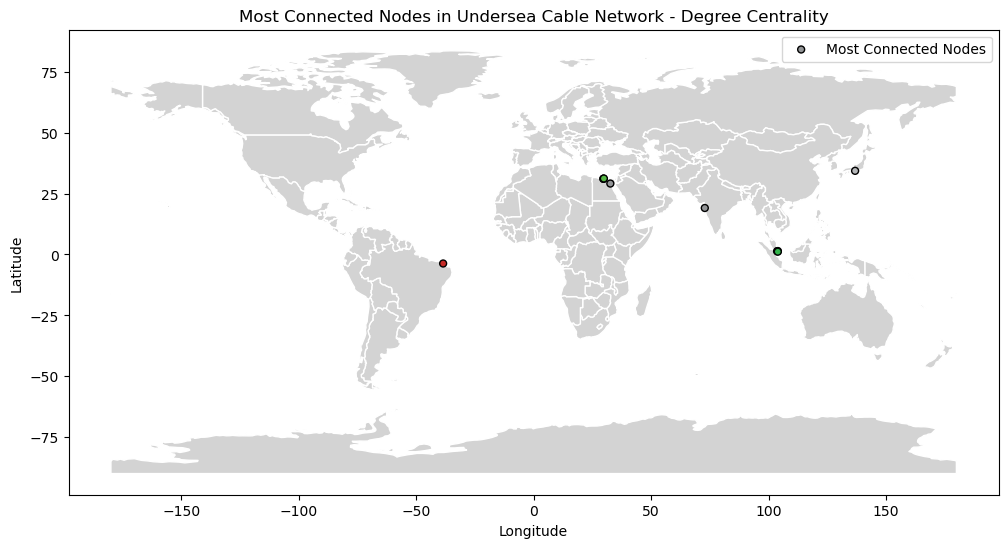

In [ ]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
degree_centrality_ordered = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
most_connected_nodes = [x[0] for x in degree_centrality_ordered[0:top_n]]
degree_centrality = [x[1] for x in degree_centrality_ordered[0:top_n]]

# Get the GeoDataFrame of the most connected nodes
top_nodes_gdf = gdf_nodes[gdf_nodes["node_id"].isin(most_connected_nodes)].copy()
# Merge with original gdf to get cable color

top_nodes_gdf = pd.merge(top_nodes_gdf, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left"
)[["node_id", "cable_id", "geometry", "color"]].head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot a world basemap (you might need to adjust the path)
world = gpd.read_file("./data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
top_nodes_gdf.plot(ax=ax, color=top_nodes_gdf.color, edgecolor="black", markersize=25, label="Most Connected Nodes")
ax.set_title("Most Connected Nodes in Undersea Cable Network - Degree Centrality")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


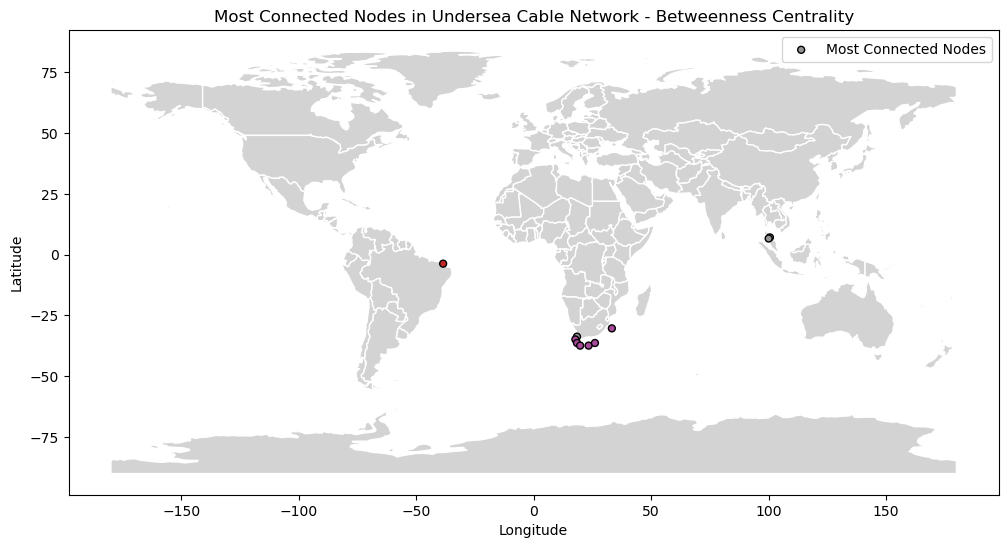

In [ ]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_ordered = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
most_connected_nodes = [x[0] for x in betweenness_centrality_ordered[0:top_n]]
betweenness_centrality = [x[1] for x in betweenness_centrality_ordered[0:top_n]]

# Get the GeoDataFrame of the most connected nodes
top_nodes_gdf = gdf_nodes[gdf_nodes["node_id"].isin(most_connected_nodes)].copy()
# Merge with original gdf to get cable color

top_nodes_gdf = pd.merge(top_nodes_gdf, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left"
)[["node_id", "cable_id", "geometry", "color"]].head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot a world basemap (you might need to adjust the path)
world = gpd.read_file("./data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
top_nodes_gdf.plot(ax=ax, color=top_nodes_gdf.color, edgecolor="black", markersize=25, label="Most Connected Nodes")
ax.set_title("Most Connected Nodes in Undersea Cable Network - Betweenness Centrality")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()
